In [1]:
import gc
from operator import concat
import kagglehub
import kagglehub.config
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from sentry_sdk.utils import epoch
from torch.xpu import device
from torchmetrics.functional import precision

import wandb
import pytorch_lightning.loggers as wandb_logger
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50
from RoadDataLoader import RoadDataLoader

In [2]:
# get kaggle.json file form ./kaggle.json
with open("./kaggle.json", "r") as f:
    kaggle_json = json.load(f)
kaggel_username = kaggle_json["username"]
kaggel_key = kaggle_json["key"]

In [4]:
kagglehub.config.set_kaggle_credentials(kaggel_username, kaggel_key)

Kaggle credentials set.


In [5]:
# Download latest version
path = kagglehub.dataset_download("payne18/road-detection-dataset-with-masks")
#make data folder if not existing
if not os.path.exists("./data"):
    os.mkdir("./data")
# Move data folder to ./data
os.system(f"mv {path} ./data/road-detection-dataset-with-masks")
# remove empty folder
folder_to_remove = path.split("payne18/road-detection-dataset-with-masks")[0] 
os.system((f"rm -r {folder_to_remove}"))

100%|██████████| 3.81G/3.81G [02:31<00:00, 27.0MB/s]

Extracting files...


0

# Lightining module

In [30]:
def dice_score(pred, target, smooth=1e-4):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

def iou_score(pred, target, smooth=1e-4):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [3]:
class RoadSegmentationModule(pl.LightningModule):
    def __init__(self, model, loss_fn, optimizer, only_last_layer=False, weight_decay=0.01, lr=1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.precision_fn = torchmetrics.Precision(task="binary")
        self.optimizer = optimizer
        self.lr = lr
        self.only_last_layer = only_last_layer
        self.weight_decay = weight_decay
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        if y.shape != pred.shape:
            pred = pred.squeeze(1)
        loss = self.loss_fn(pred, y)
        precision = self.precision_fn(pred, y)
        dice = dice_score(pred, y)
        iou = iou_score(pred, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_precision", precision, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_dice", dice, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_iou", iou, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        if y.shape != pred.shape:
            pred = pred.squeeze(1)
        loss = self.loss_fn(pred, y)
        precision = self.precision_fn(pred, y)
        dice = dice_score(pred, y)
        iou = iou_score(pred, y)
        
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_precision", precision, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_dice", dice, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_iou", iou, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        if self.optimizer == "Adam":
            if self.only_last_layer:
                opt = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr)
            else:
                opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer == "AdamW":
            if self.only_last_layer:
                opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr, weight_decay=self.weight_decay)
            else:
                opt = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError("Optimizer not implemented in RoadSegmentationModule")
        return opt


# Baseline models

In [4]:
class DeepLabV3Model(torch.nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = deeplabv3_resnet50(pretrained=pretrained)
        
        self.model.classifier[4] = nn.Conv2d(
            in_channels=self.model.classifier[4].in_channels,
            out_channels=1,
            kernel_size=self.model.classifier[4].kernel_size,
            stride=self.model.classifier[4].stride,
            padding=self.model.classifier[4].padding
        )
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False
            
            # Csak az utolsó réteg paramétereinek engedélyezése a tanításra
            for param in self.model.classifier[4].parameters():
                param.requires_grad = True
        
    def forward(self, x):
        return self.model(x)["out"]

In [5]:
class FCNR50Model(torch.nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = fcn_resnet50(pretrained=pretrained)
        
        self.model.classifier[4] = nn.Conv2d(
            in_channels=self.model.classifier[4].in_channels,
            out_channels=1,
            kernel_size=self.model.classifier[4].kernel_size,
            stride=self.model.classifier[4].stride,
            padding=self.model.classifier[4].padding
        )
        
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False
            
           
            for param in self.model.classifier[4].parameters():
                param.requires_grad = True
        
        
    def forward(self, x):
        return self.model(x)["out"]

In [6]:
class UNET2D(nn.Module):
    def __init__(self, in_channels, out_channels, chanel_list=[8, 16, 32, 64]):
        super(UNET2D, self).__init__()
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels

        for out_channel in chanel_list:
            self.down_blocks.append(
                nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU(),
                    nn.Conv2d(out_channel, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
            self.in_channels = out_channel

        for out_channel in reversed(chanel_list):
            self.up_blocks.append(
                nn.ConvTranspose2d(out_channel * 2, out_channel, 2, 2)
            )
            self.up_blocks.append(
                nn.Sequential(
                    nn.Conv2d(out_channel * 2, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU(),
                    nn.Conv2d(out_channel, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
            self.in_channels = out_channel

            self.bottleneck = nn.Sequential(
                nn.Conv2d(chanel_list[-1], chanel_list[-1]*2, 3, padding=1),
                nn.BatchNorm2d(chanel_list[-1]*2),
                nn.ReLU(),
                nn.Conv2d(chanel_list[-1]*2, chanel_list[-1]*2, 3, padding=1),
                nn.BatchNorm2d(chanel_list[-1]*2),
                nn.ReLU()
            )

            self.final_block = nn.Conv2d(chanel_list[0], out_channels, 1)

    def forward(self, x):
        skip_connections = []
        for block in self.down_blocks:
            x = block(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2, 2)(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]


        for idx in range(0, len(self.up_blocks), 2):
            x = self.up_blocks[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='bilinear')

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.up_blocks[idx + 1](concat_skip)

        return self.final_block(x)

# LOAD DATA

In [7]:
data_path = os.path.abspath("./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset")
metadata_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/metadata.csv"

In [8]:
#open metadata
metadata = pd.read_csv(metadata_path)
print(f"All data: {metadata.shape[0]}")

All data: 8570


In [9]:
metadata = metadata[metadata["split"] == "train"]
print(f"Data withouth validation and test: {metadata.shape[0]}")
metadata["sat_image_path"] = metadata["sat_image_path"].apply(lambda x: os.path.join(data_path, x))
metadata["mask_path"] = metadata["mask_path"].apply(lambda x: os.path.join(data_path, x))
metadata.head()

Data withouth validation and test: 6226


image_id  split                                     sat_image_path  \
0    100034  train  /home/ad.adasworks.com/bence.panczel/Documents...   
1    100081  train  /home/ad.adasworks.com/bence.panczel/Documents...   
2    100129  train  /home/ad.adasworks.com/bence.panczel/Documents...   
3    100703  train  /home/ad.adasworks.com/bence.panczel/Documents...   
4    100712  train  /home/ad.adasworks.com/bence.panczel/Documents...   

                                           mask_path  
0  /home/ad.adasworks.com/bence.panczel/Documents...  
1  /home/ad.adasworks.com/bence.panczel/Documents...  
2  /home/ad.adasworks.com/bence.panczel/Documents...  
3  /home/ad.adasworks.com/bence.panczel/Documents...  
4  /home/ad.adasworks.com/bence.panczel/Documents...

# Training

In [15]:
def dice_loss(pred, target, smooth=1e-4):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = 1 - (2 * intersection + smooth) / (union + smooth)
    return dice

def combined_loss(pred, target, alpha=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return alpha * bce + (1 - alpha) * dice

In [16]:
# hyperparameters
batch_size = 8
optimizer = "Adam"
lr = 1e-4
weight_decay = 0.01
epochs = 10
loss_fn = combined_loss
accelerator = "auto"
pretrained = False
image_size = 512
num_workers = 8

In [12]:
dataLoader = RoadDataLoader(metadata, batch_size=batch_size, image_size=image_size, num_workers=num_workers)
# dataLoader.setup()
dataLoader.train_data = pd.read_csv("./metadata/traindata.csv", index_col=0)
dataLoader.val_data = pd.read_csv("./metadata/valdata.csv", index_col=0)
dataLoader.test_data = pd.read_csv("./metadata/testdata.csv", index_col=0)

In [13]:
train_data_loader = dataLoader.train_dataloader()
val_data_loader = dataLoader.val_dataloader()

In [14]:
# save dataLoader.traindata, dataLoader.valdata and dataLoader.testdata to csv
# dataLoader.train_data.to_csv("./metadata/traindata.csv")
# dataLoader.val_data.to_csv("./metadata/valdata.csv")
# dataLoader.test_data.to_csv("./metadata/testdata.csv")

# Trainig with DeepLabV3Model

In [14]:
wandb.login()
model = DeepLabV3Model(pretrained=pretrained)
module = RoadSegmentationModule(model, loss_fn, optimizer)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="DeepLabV3Model")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: panczebence (panczebence-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
/home/ad.adasworks.com/bence.panczel/miniconda3/envs/melytanulas_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ad.adasworks.com/bence.panczel/miniconda3/envs/melytanulas_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(module, train_data_loader, val_data_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type            | Params | Mode 
---------------------------------------------------------
0 | model        | DeepLabV3Model  | 39.6 M | train
1 | precision_fn | BinaryPrecision | 0      | train
2 | optimizer    | BinaryAccuracy  | 0      | train
---------------------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.535   Total estimated model params size (MB)
186       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
wandb.finish()
depplabv3_model_path = checkpoint_callback.best_model_path
print(depplabv3_model_path)

./road-segmentation/vkz3cshf/checkpoints/epoch=8-step=5049.ckpt


In [17]:
# save the best bodel as DeepLabV3_best_model.cpkt
!cp {depplabv3_model_path} ./models//DeepLabV3_best_model.cpkt

# Trainig with UNET2D

In [14]:
dataLoader.batch_size = 8
train_data_loader = dataLoader.train_dataloader()
val_data_loader = dataLoader.val_dataloader()

In [15]:
wandb.login()
model = UNET2D(3, 1, chanel_list=[8, 16, 32, 64])
module = RoadSegmentationModule(model, loss_fn, optimizer)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="UNET2D")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: panczebence (panczebence-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(module, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type            | Params | Mode 
---------------------------------------------------------
0 | model        | UNET2D          | 487 K  | train
1 | precision_fn | BinaryPrecision | 0      | train
---------------------------------------------------------
487 K     Trainable params
0         Non-trainable params
487 K     Total params
1.949     Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
wandb.finish()
unet2d_model_path = checkpoint_callback.best_model_path
print(unet2d_model_path)

./road-segmentation/lr2ii2wc/checkpoints/epoch=9-step=5610.ckpt


In [18]:
# save the best bodel as UNET2D_best_model.cpkt
!cp {unet2d_model_path} ./models/UNET2D_best_model.cpkt

# Testing models

In [144]:
def show_result(x, y, pred, title, sigmoid=True):
    if sigmoid:
        pred = torch.sigmoid(pred)
    fig, ax = plt.subplots(4, 3, figsize=(15, 25))
    fig.suptitle(title)
    for i in range(4):
        # denormalize x
        image = x[i] * 0.5 + 0.5
        ax[i, 0].imshow(image.permute(1, 2, 0))
        ax[i, 0].set_title("Input")
        ax[i, 0].axis("off")
        ax[i, 1].imshow(y[i].squeeze(0))
        ax[i, 1].set_title("Target")
        ax[i, 1].axis("off")
        ax[i, 2].imshow(pred[i].squeeze(0).detach().numpy())
        ax[i, 2].set_title("Prediction")
        ax[i, 2].axis("off")
    #thight layout
    plt.tight_layout()
    plt.show()

In [145]:
import time

def eval_model(model, dataLoader, device, model_name='model'):
    model.to(device)
    model.eval()
    
    precision = torchmetrics.Precision(task="binary").to(device)
    accuracy = torchmetrics.Accuracy(task='binary').to(device)
    
    total_IoU, total_dice, total_precision, total_accuracy = 0, 0, 0, 0
    num_batches = len(dataLoader)
    
    inference_time = []
    with torch.no_grad():
        for x, y in dataLoader:
            x = x.to(device)
            y = y.to(device)
            
            start = time.time()
            pred = model(x)
            torch.cuda.synchronize()
            end = time.time()
            
            inference_time.append(end - start)
            
            total_IoU += iou_score(pred, y)
            total_dice += dice_score(pred, y)
            
            total_precision += precision(pred, y)
            total_accuracy += accuracy(pred, y)
            
    avg_IoU = total_IoU / num_batches
    avg_dice = total_dice / num_batches
    avg_precision = total_precision / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_inference_time = sum(inference_time) / len(inference_time)
    
    print(f"{model_name} IoU: {avg_IoU}")
    print(f"{model_name} Dice: {avg_dice}")
    print(f"{model_name} Precision: {avg_precision}")
    print(f"{model_name} Accuracy: {avg_accuracy}")
    print(f"{model_name} Inference time: {avg_inference_time}")
    return avg_IoU, avg_dice, avg_precision, avg_accuracy, avg_inference_time

In [146]:
dataLoader = RoadDataLoader(metadata, batch_size=4, image_size=512, num_workers=8)
dataLoader.train_data = pd.read_csv("./metadata/traindata.csv", index_col=0)
dataLoader.val_data = pd.read_csv("./metadata/valdata.csv", index_col=0)
dataLoader.test_data = pd.read_csv("./metadata/testdata.csv", index_col=0)

In [147]:
test_dataLoader = dataLoader.test_dataloader()

for batch in test_dataLoader:
    x, y = batch
    break


In [148]:
deeplabv3_model_path = "./models/DeepLabV3_best_model.cpkt"
unet2d_model_path = "./models/UNET2D_best_model.cpkt"


### DeepLabV3Model evaluation

In [149]:
deeplabv3_state_dict = torch.load(deeplabv3_model_path)["state_dict"]
deeplabv3_state_dict = {k.replace("model.model.", "model."): v for k, v in deeplabv3_state_dict.items()}
deeplabv3_model = DeepLabV3Model(pretrained=False)
deeplabv3_model.load_state_dict(deeplabv3_state_dict, strict=False)
deeplabv3_module = RoadSegmentationModule(deeplabv3_model, combined_loss, optimizer)

/tmp/ipykernel_2780949/3193918698.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplabv3_state_dict = torch.load(deeplabv3_model_path)["state_dict"]
/home/ad.adaswork

In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"
deeplabv3_module.to(device)
x = x.to(device)
y = y.to(device)

deeplabv3_module.eval()
pred = deeplabv3_module(x)

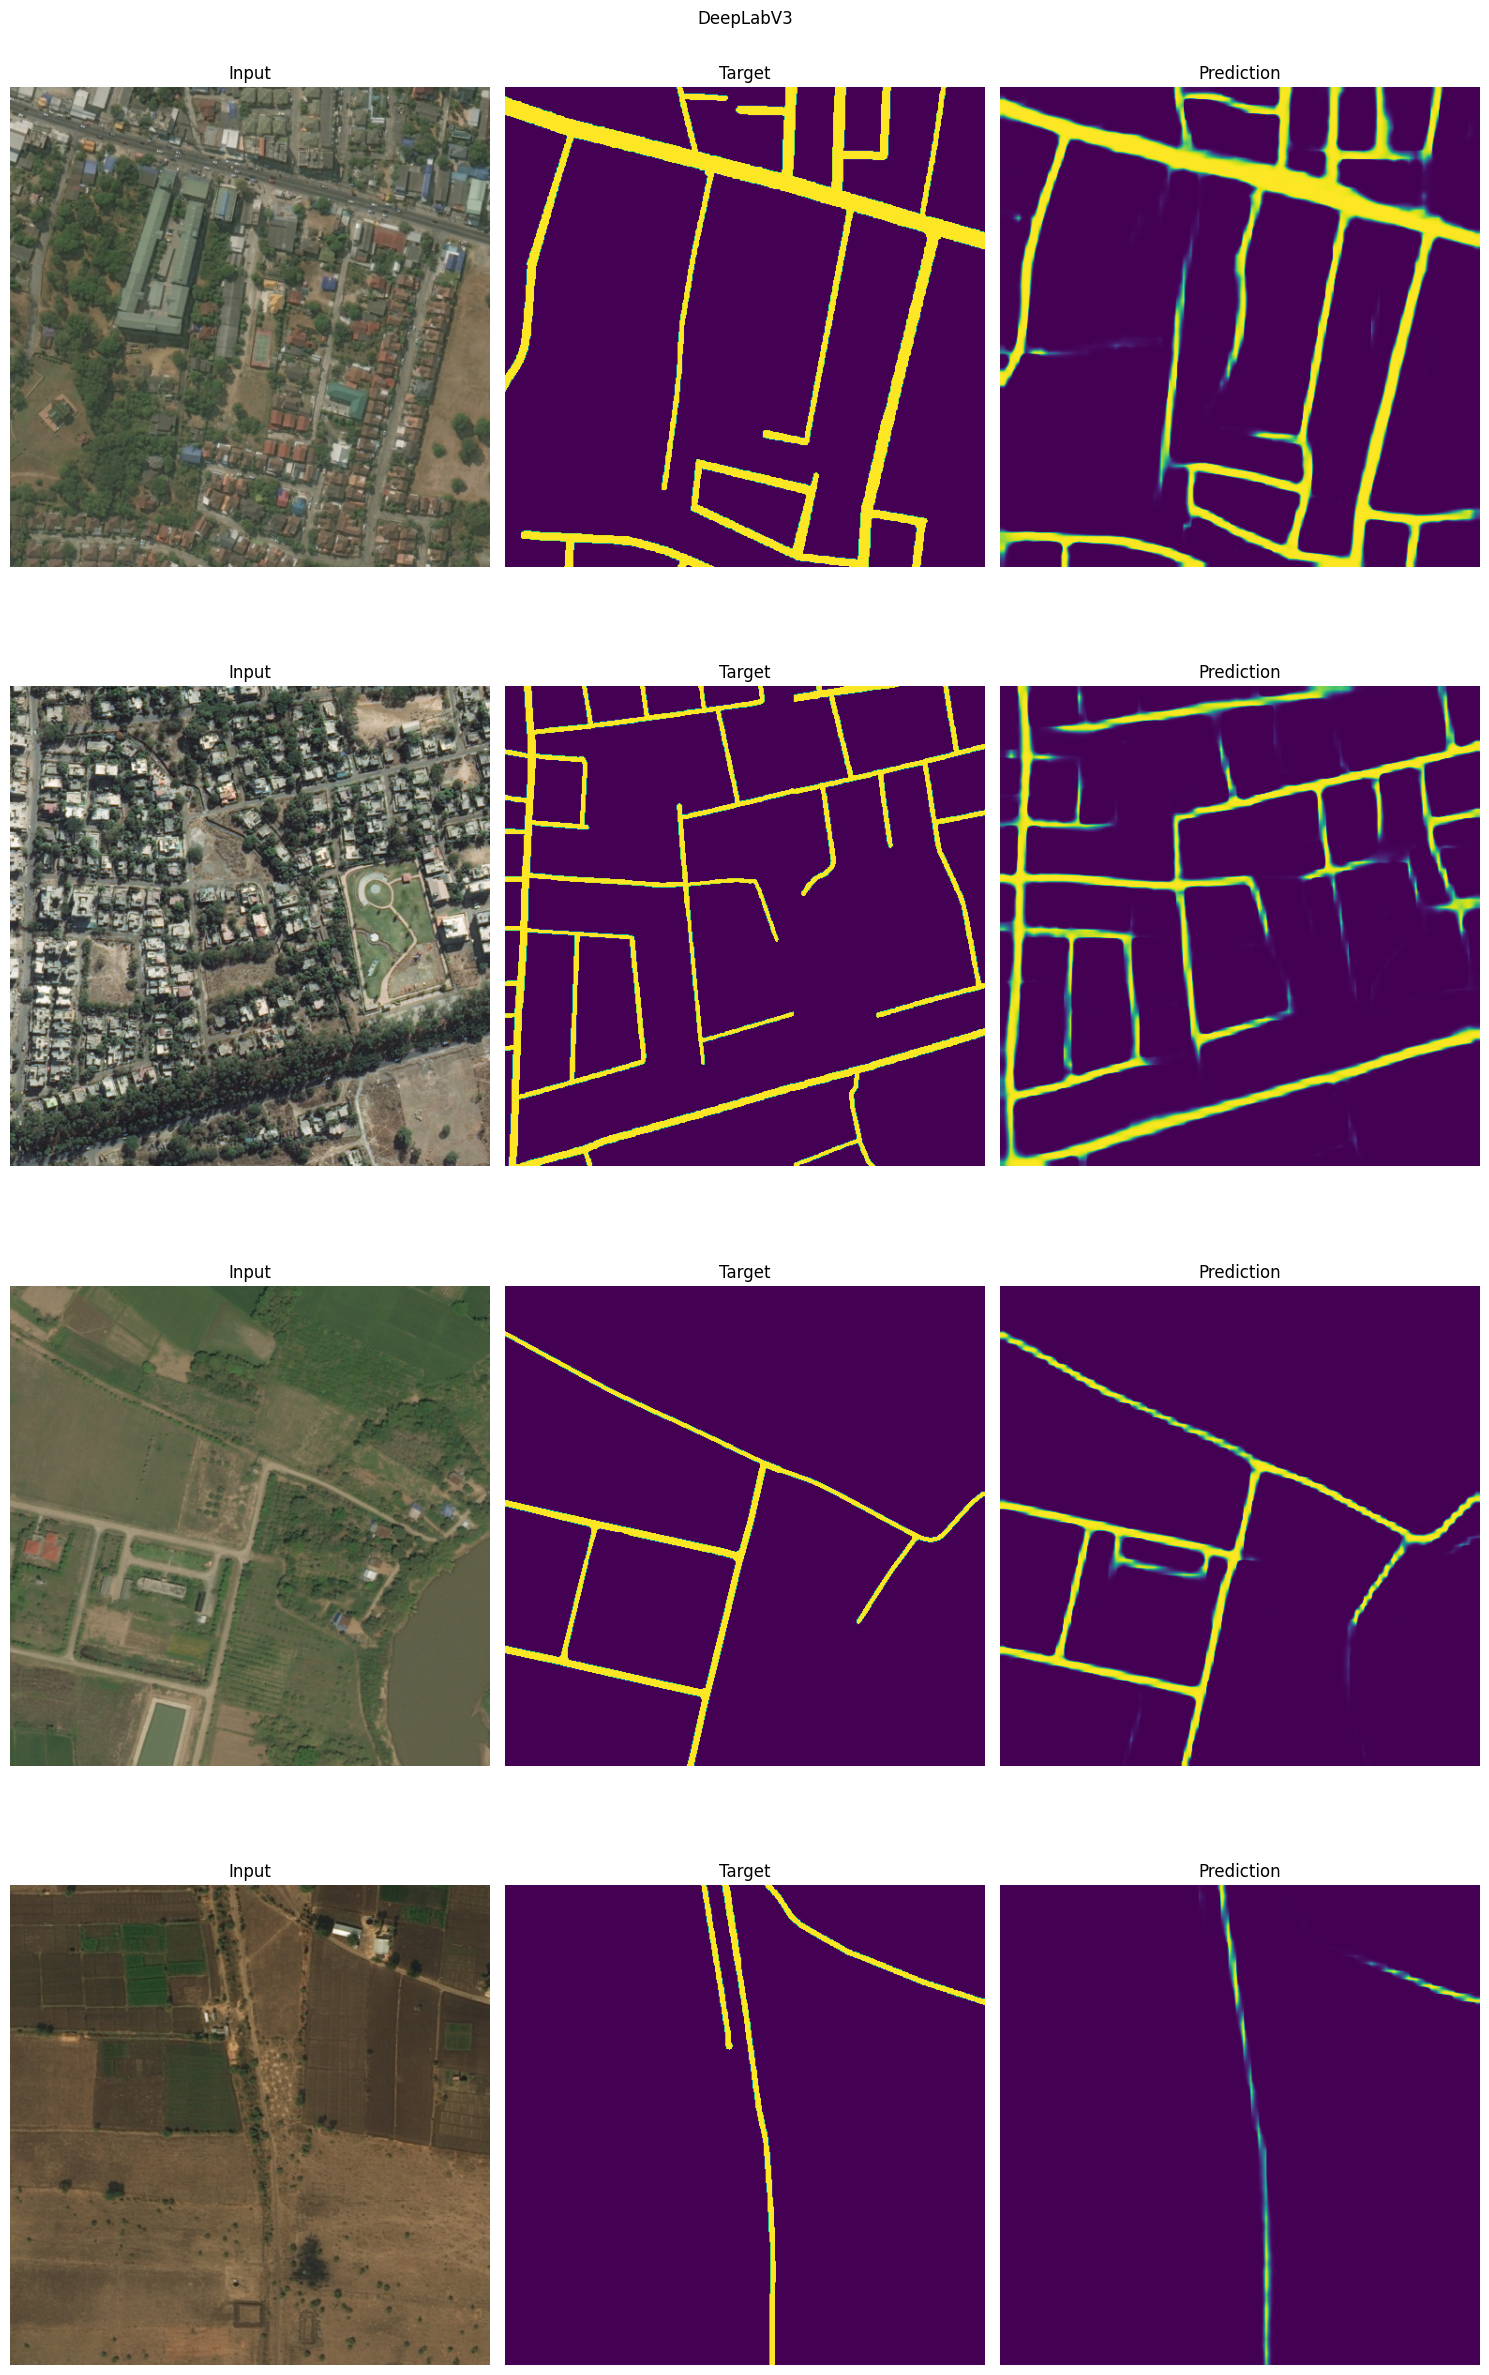

In [151]:
show_result(x.cpu(), y.cpu(), pred.cpu(), "DeepLabV3", sigmoid=True)

In [152]:
test_dataLoader = dataLoader.test_dataloader()
DLV3_avg_IoU, DLV3_avg_dice, DLV3_avg_precision, DLV3_avg_accuracy, DLV3_avg_inference_time = eval_model(deeplabv3_module, test_dataLoader, device, "DeepLabV3")

DeepLabV3 IoU: 0.5024120211601257
DeepLabV3 Dice: 0.6655483841896057
DeepLabV3 Precision: 0.7164903283119202
DeepLabV3 Accuracy: 0.9749718308448792
DeepLabV3 Inference time: 0.2354616985321045


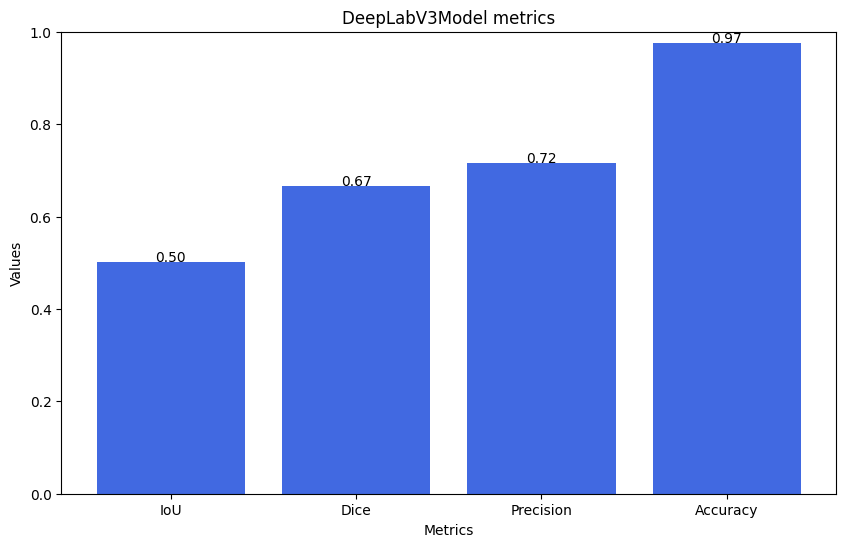

In [153]:
# show result
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
values = [DLV3_avg_IoU.cpu(), DLV3_avg_dice.cpu(), DLV3_avg_precision.cpu(), DLV3_avg_accuracy.cpu()]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='royalblue')

plt.title('DeepLabV3Model metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='center')


plt.show()

### UNET2D evaluation

In [154]:
unet2d_state_dict = torch.load(unet2d_model_path)["state_dict"]
unet2d_state_dict = {k.replace("model.", ""): v for k, v in unet2d_state_dict.items()}
unet2d_model = UNET2D(3, 1, chanel_list=[8, 16, 32, 64])
unet2d_model.load_state_dict(unet2d_state_dict, strict=False)
unet2d_module = RoadSegmentationModule(unet2d_model, loss_fn, optimizer)


/tmp/ipykernel_2780949/887313176.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet2d_state_dict = torch.load(unet2d_model_path)["state_dict"]


In [155]:
device = "cuda" if torch.cuda.is_available() else "cpu"
unet2d_module.to(device)
x = x.to(device)
y = y.to(device)

unet2d_module.eval()
pred = unet2d_module(x)

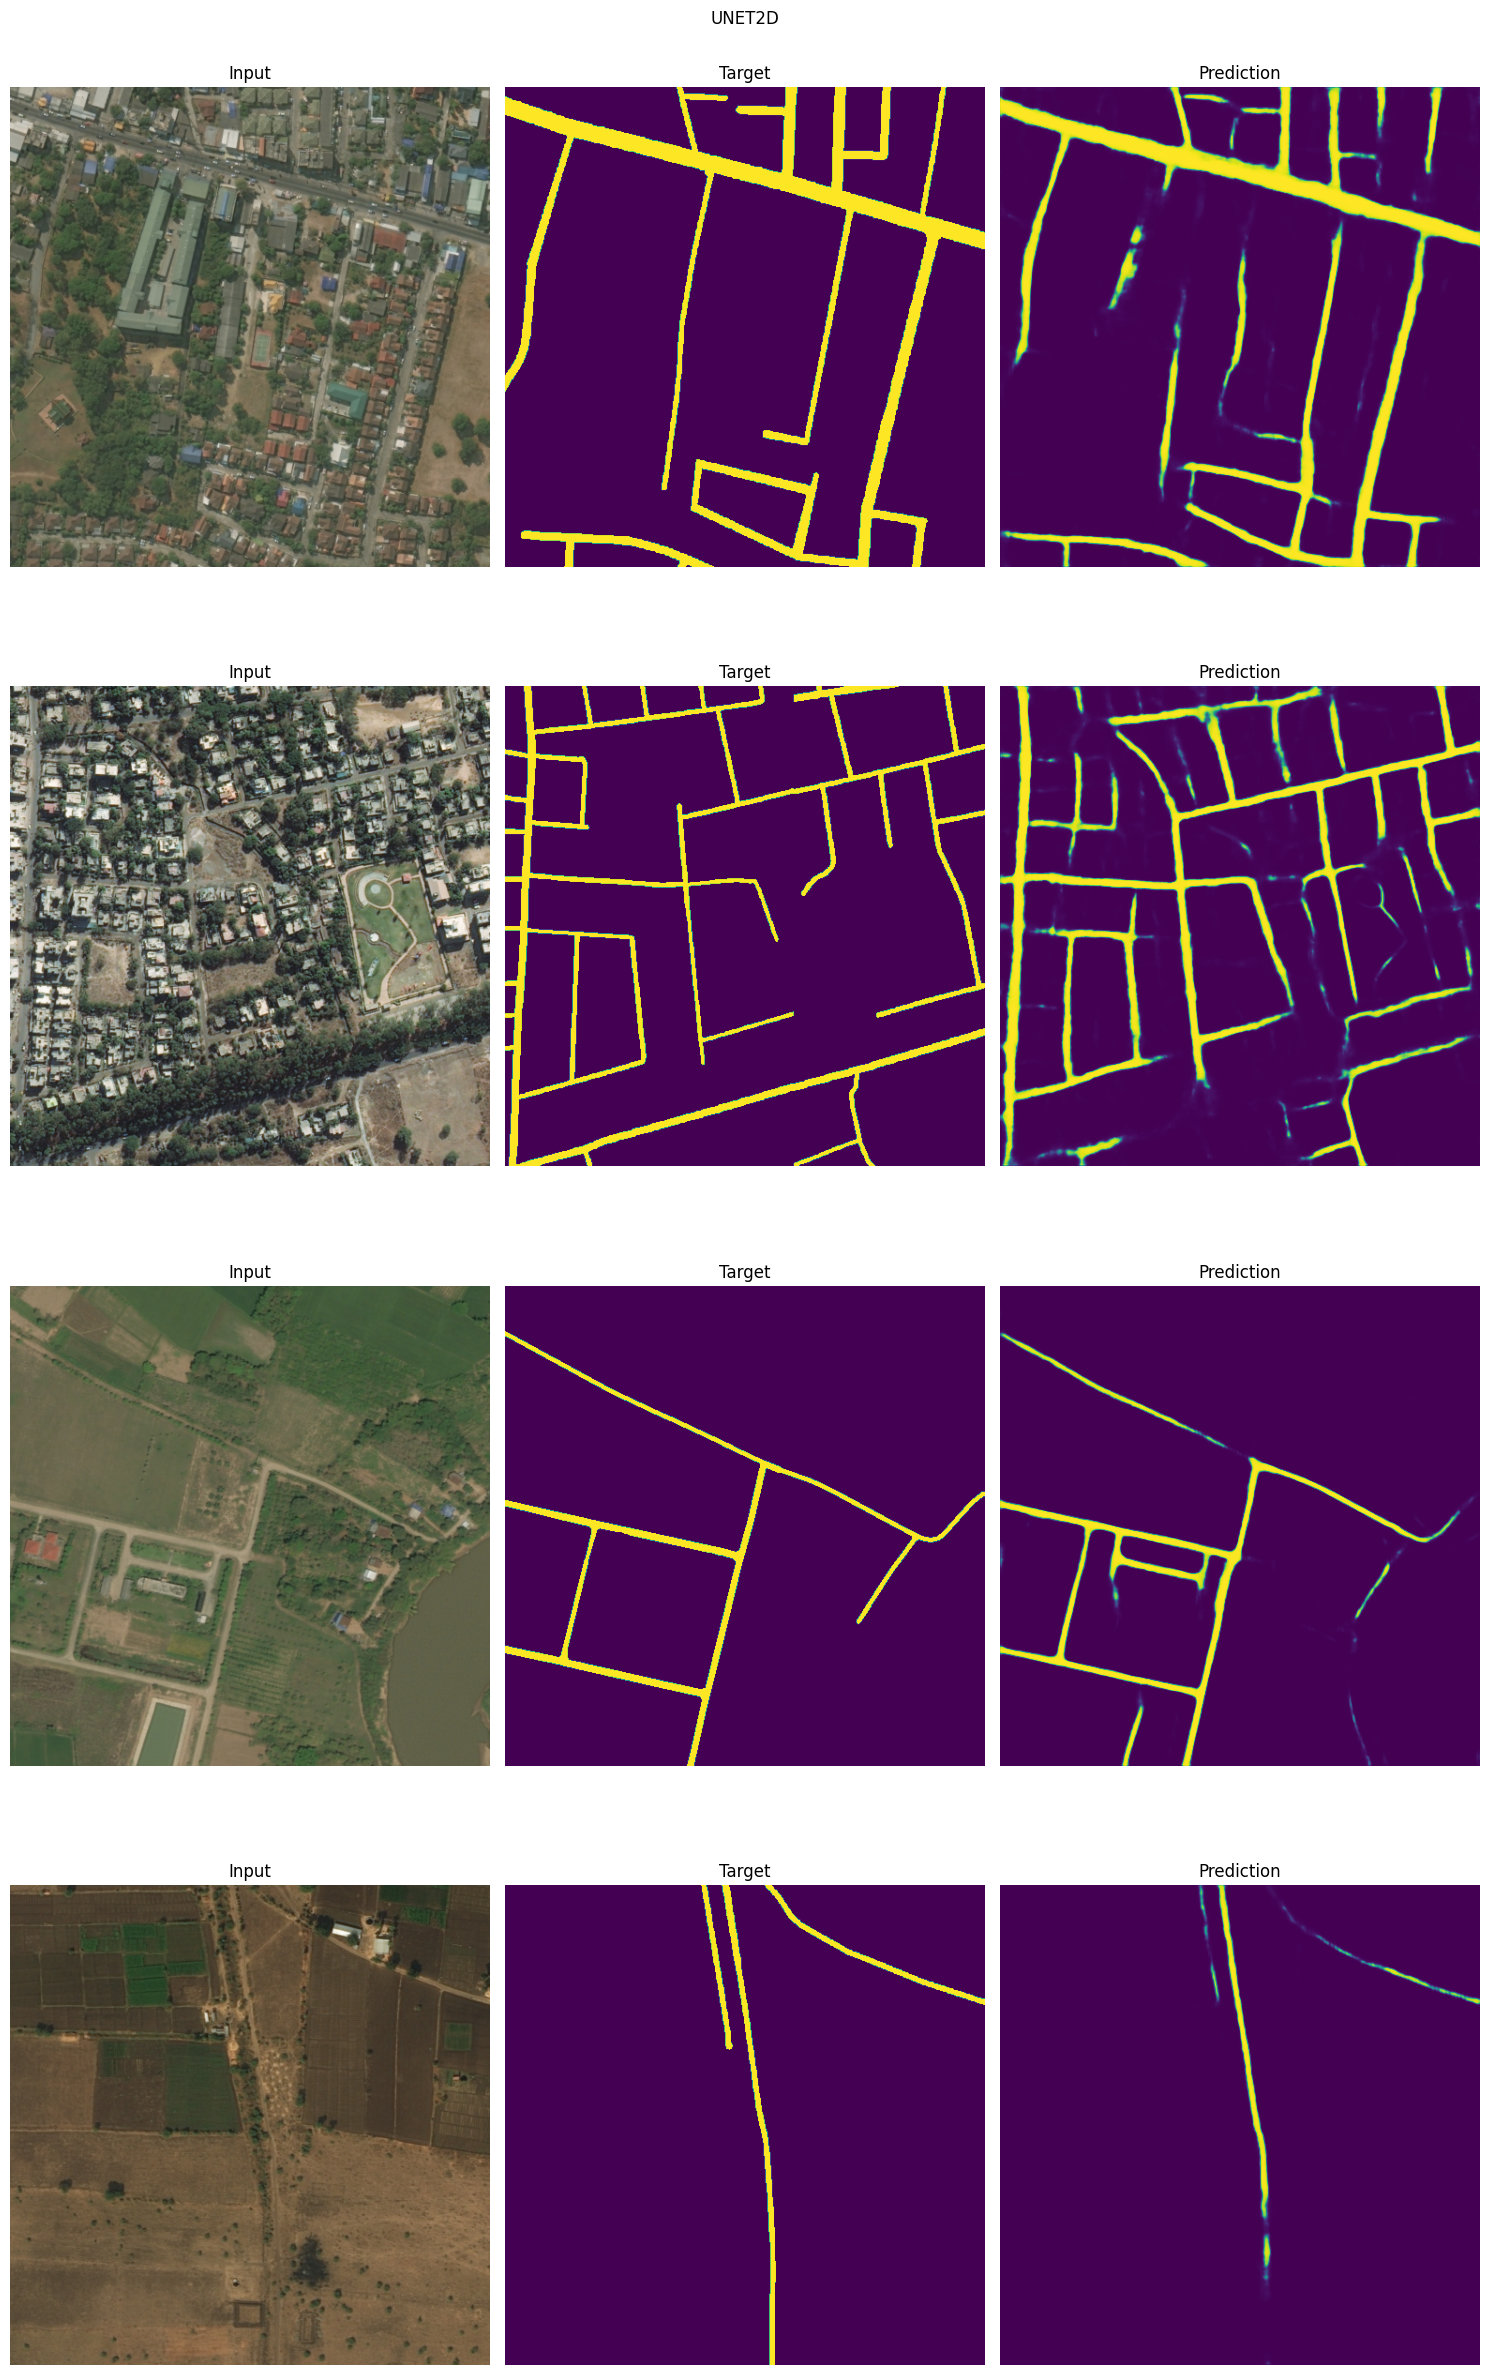

In [156]:
show_result(x.cpu(), y.cpu(), pred.cpu(), "UNET2D", sigmoid=True)

In [157]:
test_dataLoader = dataLoader.test_dataloader()
UNET2D_avg_IoU, UNET2D_avg_dice, UNET2D_avg_precision, UNET2D_avg_accuracy, UNET2D_avg_inference_time = eval_model(unet2d_module, test_dataLoader, device, "UNET2D")

UNET2D IoU: 0.47128453850746155
UNET2D Dice: 0.6371495127677917
UNET2D Precision: 0.6791139245033264
UNET2D Accuracy: 0.9721116423606873
UNET2D Inference time: 0.016132766723632813


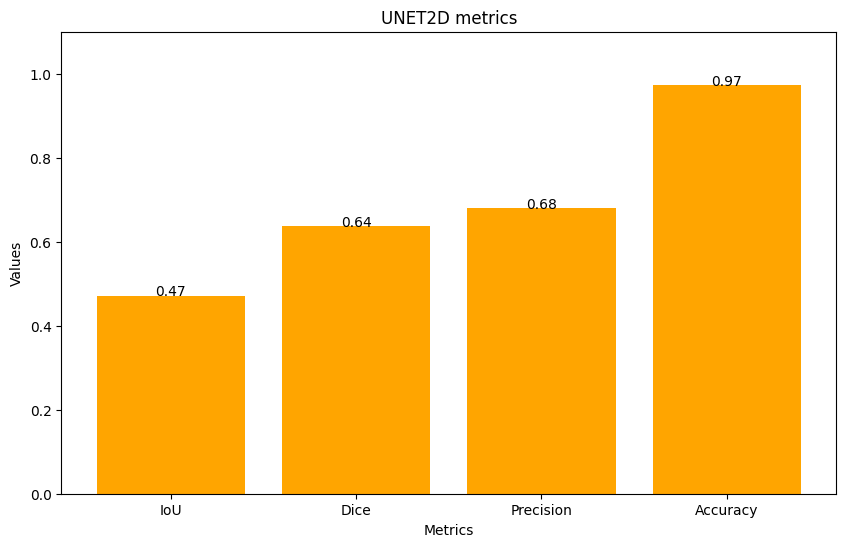

In [158]:
# show result
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
values = [UNET2D_avg_IoU.cpu(), UNET2D_avg_dice.cpu(), UNET2D_avg_precision.cpu(), UNET2D_avg_accuracy.cpu()]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='orange')

plt.title('UNET2D metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1.1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='center')
    
plt.show()

### Comparison

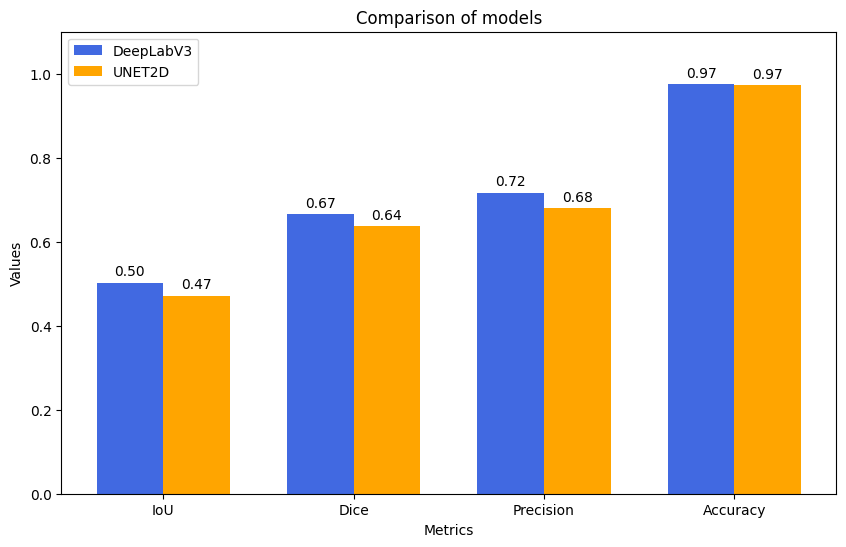

In [159]:
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
u2_values = [UNET2D_avg_IoU.cpu(), UNET2D_avg_dice.cpu(), UNET2D_avg_precision.cpu(), UNET2D_avg_accuracy.cpu()]
d3_values = [DLV3_avg_IoU.cpu(), DLV3_avg_dice.cpu(), DLV3_avg_precision.cpu(), DLV3_avg_accuracy.cpu()]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, d3_values, width, label='DeepLabV3', color='royalblue')
bar2 = ax.bar(x + width/2, u2_values, width, label='UNET2D', color='orange')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of models')
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def add_label(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 ponttal feljebb
                    textcoords="offset points",
                    ha='center', va='bottom')
        
add_label(bar1)
add_label(bar2)


plt.show()

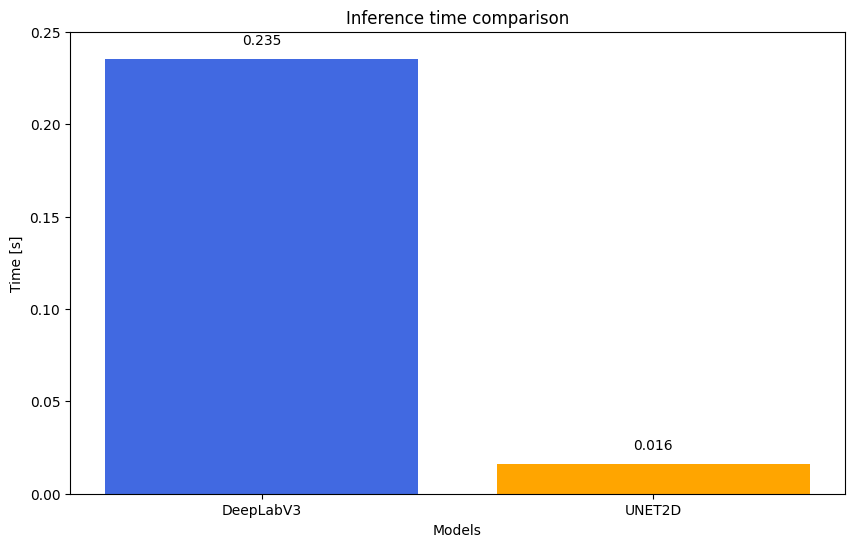

In [160]:
# compate inference time
inference_times = [DLV3_avg_inference_time, UNET2D_avg_inference_time]
models = ['DeepLabV3', 'UNET2D']

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['royalblue', 'orange'])

plt.title('Inference time comparison')
plt.ylabel('Time [s]')
plt.xlabel('Models')
plt.ylim(0, 0.25)

for i, v in enumerate(inference_times):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='center')


plt.show()